# Experiment results

In [2]:
import yaml
import os
import importlib
import numpy as np
import matplotlib.pyplot as plt

from src.lib import plotting
importlib.reload(plotting)

In [3]:
os.listdir(cfg['experiment_directory'])

['no-preprocess-1.npy',
 'edain-test.npy',
 'test-experiment-2.npy',
 'min-max-1.npy',
 'standard-scaling-test.npy',
 'standard-scaler-baseline.npy',
 'mixed-preprocessing-test-1.npy',
 'test-experiment-1.npy']

In [30]:
hist_baseline = plotting.load_hist("standard-scaler-baseline")
hist_min_max = plotting.load_hist("min-max-1")
hist_mixed = plotting.load_hist("mixed-preprocessing-test-1")
hist_nothing = plotting.load_hist("no-preprocess-1")

(0.2, 0.23)

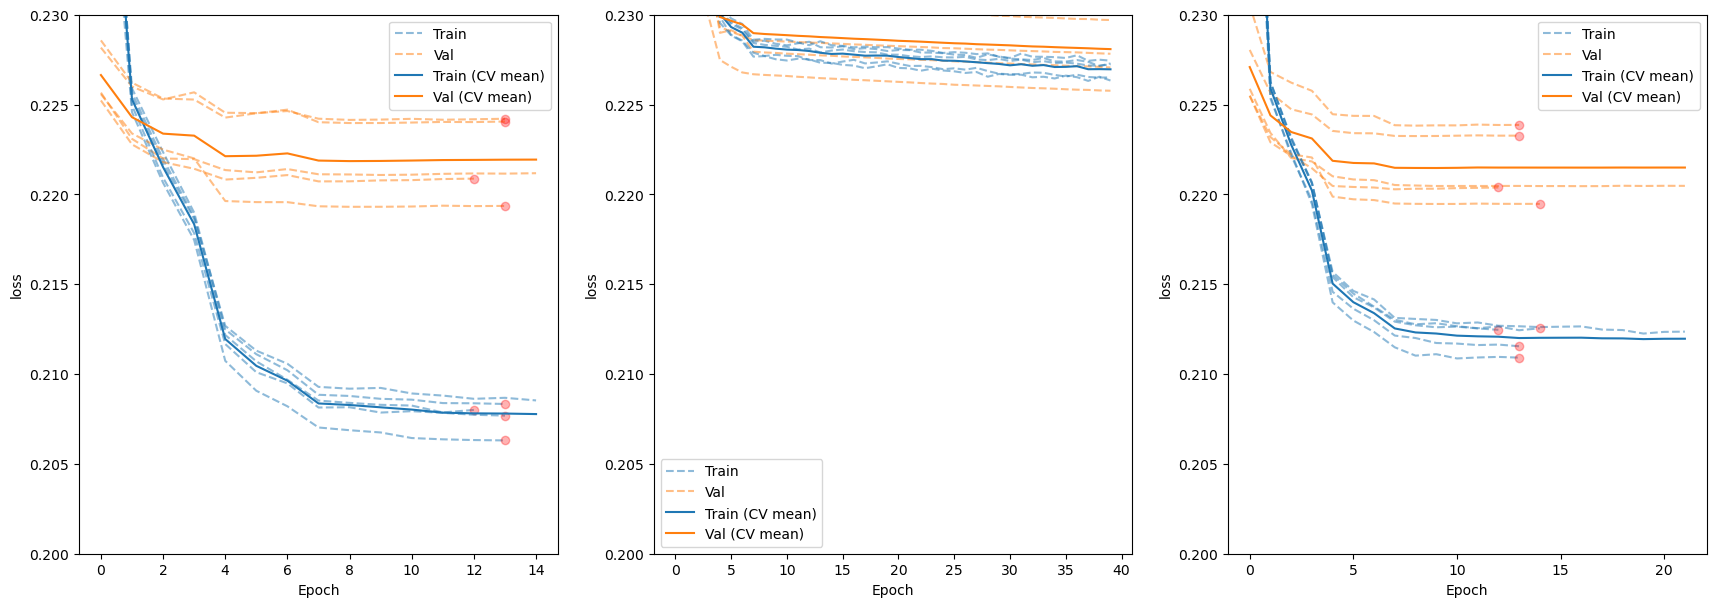

In [14]:
fig, axs = plt.subplots(ncols=3, figsize=(21, 7))
plotting.plot_cv(hist_baseline, "loss", axs[0])
plotting.plot_cv(hist_min_max, "loss", axs[1])
plotting.plot_cv(hist_mixed, "loss", axs[2])
axs[0].set_ylim([0.20, 0.23])
axs[1].set_ylim([0.20, 0.23])
axs[2].set_ylim([0.20, 0.23])

In [28]:
def compare_hists(histories, labels, key, ax, cols=None):
    if cols is None:
        cols = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:orange', 'black', 'grey']
    assert len(histories) <= len(cols) and "Not enough colours specified"
    
    for hist, c, l in zip(histories, cols, labels):
        cv_avgs = plotting.get_average(hist, key)
        ax.plot(cv_avgs, label = f"{l} ({cv_avgs[-1]:.4f})", color=c)
        ax.plot(len(cv_avgs) - 1, cv_avgs[-1], marker='o', color=c)
    ax.legend(title=f"Preprocessing method ({key})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(key)

(0.21, 0.235)

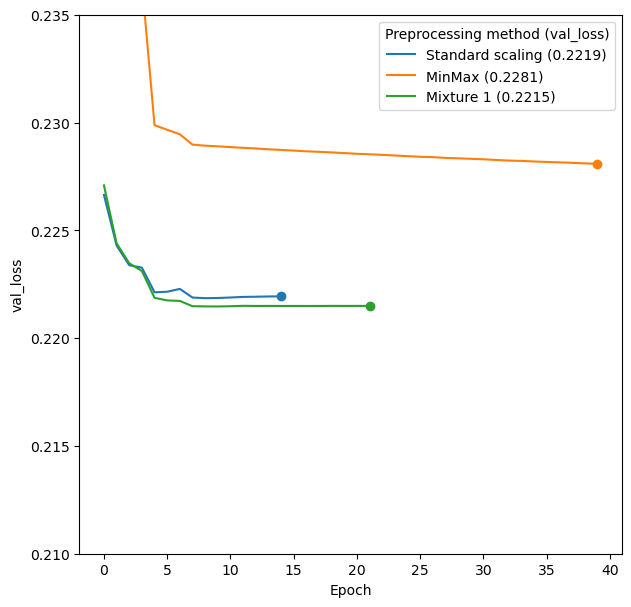

In [34]:
fig, ax = plt.subplots(figsize=(7, 7))
compare_hists([hist_baseline, hist_min_max, hist_mixed], ["Standard scaling", "MinMax", "Mixture 1"], "val_loss", ax)
ax.set_ylim([0.21, 0.235])